(start:boundsAndInitialization)=
# Fitting bounds and parameter initialization

## Lesson overview

Now that we know how to [fit a data set](start:basicsFitting), 
[include uncertainty estimates to a fit](start:curve_fit_unc), and 
[quantify how well a fit matches a data set](start:basicsFitting), lets begin to explore a few other useful concepts 
in fitting. In this lesson we will explore two important aspects when fitting data: (1) setting bound limits to a fit 
and (2) initializing fitting parameters.

## Topics taught / reviewed

* Setting a fit range.
* Initializing fitting parameters.

## Setting bound limits to a fit

To demonstrate why we would want to only fit a portion of a data set, let's utilize data collected from a 
tensile test. This type of test involves pulling a sample uniaxially (i.e., in one direction) 
until it permanently deforms or breaks. The {download}`data<./example_data/ElasticModulus_analysis.csv>` we will use in 
this example is from a metallic sample. The file contains two measurable quantities: strain and stress. Strain values 
represent how much the sample was pulled relative to its starting length (this is a unitless value), and stress values 
represent how much force relative to the sample's starting cross-sectional area that the sample experienced (units: 
Pa). Furthermore, estimates on the measurement uncertainty for both stress and strain are also provided in the data.




Let's first load the data into a Python environment and plot the data using Matplotlib. The code block below 
contains all the necessary commands needed to do this:

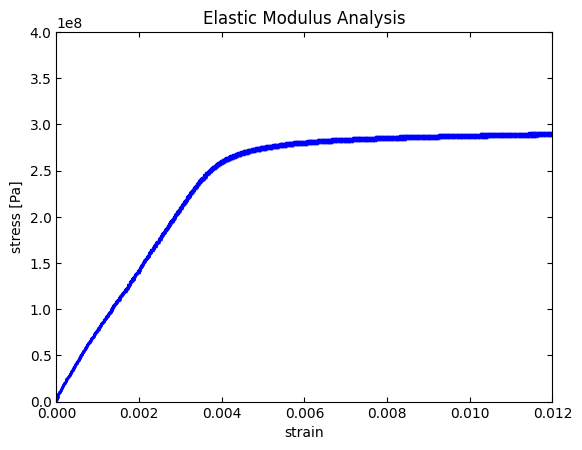

In [1]:
# Load libraries
import numpy as np
from matplotlib import pyplot as plt

# Load data
data = np.loadtxt("./example_data/ElasticModulus_analysis.csv", 
                   delimiter=",", 
                   skiprows=2)
# Data file has the following columns:
    # Column 0: strain
    # Column 1: uncertainty on strain
    # Column 2: stress [Pa]
    # Column 3: uncertainty on stress [Pa]

# Save relevant data to variables
strain = data[:, 0]
u_strain = data[:, 1]
stress = data[:, 2]
u_stress = data[:, 3]

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data
ax.errorbar(strain, stress,
            yerr=u_stress,
            label="measured data",
            marker="o",
            markersize=1,
            linestyle="none",
            color="blue",
            capsize=1)

# Figure options
ax.set_title("Elastic Modulus Analysis")
ax.set_xlabel("strain")
ax.set_ylabel("stress [Pa]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
ax.set_xlim(left=0, right=0.012)
ax.set_ylim(bottom=0, top=400E6)

# Show plot
plt.show()

We can see in this figure that there is a linear rise in the stress-strain relationship up until a strain value 
~0.0037 where the data then becomes sublinear. The initial linear region is known as the 
[elastic deformation region](https://en.wikipedia.org/wiki/Deformation_(engineering)#Elastic_deformation) in which 
the bonds in the metal are pulled but do not break (similar to a spring). 
The slope of this region is equal to an important material property called the 
[elastic modulus](https://en.wikipedia.org/wiki/Elastic_modulus). Mathematically we describe the elastic modulus as,

$$
\sigma = E \epsilon
$$

where $\sigma$ is the stress, $E$ is the elastic modulus, and $\epsilon$ is the strain. So by fitting the data set 
in this region to a line equation, the slope will be the elastic modulus.

Let's try to fit the data using what we currently know. The code below goes through our previously taught route of 
creating a line equation to fit and then fitting it with the `scipy.optimize.curve_fit()`. Let's see what happens 
when we fit the data using our current plotting and fitting knowledge:

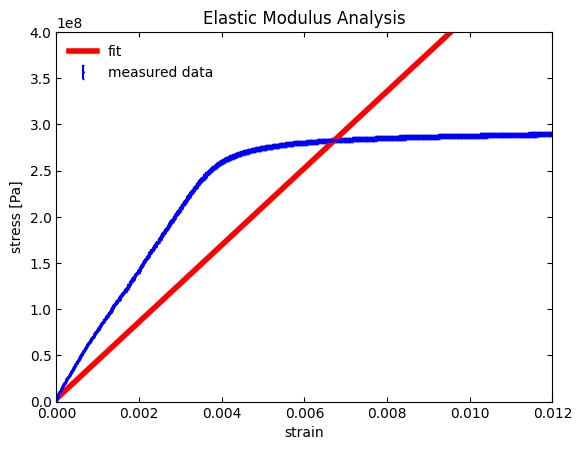

intercept = 2955084.3 Pa
intercept std. error = 5200.0 Pa
slope = 41607774372.8 Pa
slope std. error = 12244482.6 Pa
R squared: 0.12646


In [2]:
# Load SciPy to fit
from scipy.optimize import curve_fit

# Create function to fit
def linearFunc(x, intercept, slope):
    y = intercept + slope * x
    return y

# Perform the least-squares fitting
popt, pcov = curve_fit(linearFunc, strain, stress, sigma=u_stress, absolute_sigma=True)

# Extract out the fitted parameters and standard errors
intercept = popt[0]
slope = popt[1]
intercept_err = np.sqrt(pcov[0][0])
slope_err = np.sqrt(pcov[1][1])

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data
ax.errorbar(strain, stress,
            yerr=u_stress,
            label="measured data",
            marker="o",
            markersize=1,
            linestyle="none",
            color="blue",
            capsize=1)

# Create fitted curve
yfit = (slope * strain) + intercept

# Plot fit data
ax.plot(strain, yfit, 
        color="red",
        label="fit",
        linestyle="solid",
        linewidth=4)

# Figure options
ax.set_title("Elastic Modulus Analysis")
ax.set_xlabel("strain")
ax.set_ylabel("stress [Pa]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
ax.set_xlim(left=0, right=0.012)
ax.set_ylim(bottom=0, top=400E6)
ax.legend(frameon=False)

# Show plot
plt.show()

# R^2 analysis
y_data = stress

y_mean = np.mean(y_data)
deviation_squared = (y_data - y_mean)**2
ss_tot = np.sum(deviation_squared)
error_squared = (y_data - yfit)**2
ss_res = np.sum(error_squared)
r_squared = 1 - ss_res / ss_tot

# Report values to shell
print(f"intercept = {intercept:.1f} Pa")
print(f"intercept std. error = {intercept_err:.1f} Pa")
print(f"slope = {slope:.1f} Pa")
print(f"slope std. error = {slope_err:.1f} Pa")
print(f"R squared: {r_squared:.5f}")

Well we do get a fit, but the fit includes the entire data set. Since we only want to fit the elastic deformation 
region, we need to limit (i.e., bound) the fit range. One "quick and dirty" way of doing this is to go into the original 
data file and delete all the data points after ~0.0037 in strain. This is not an elegant way to go as our plot will 
only really show a subset of the entire data. We (and more importantly others) won't be able to appreciate where 
exactly our fit is occurring with respect to the entire data set.

Instead, let's create new lists that are subsets of the original `stress` and `strain` lists. From here we can use these 
subsets as arguments into `scipy.optimize.curve_fit()`, while still retaining all the data points when we make our 
final plot.

The code below demonstrates this idea. It is similar to the code we just used, but now includes the variables 
`min_index` and `max_index` to mark the starting and stopping index positions, respectively, we want to fit over. These 
will be user defined and are based on trial and error. In this example, we will perform the fit from the 30th data 
point to the 300th data point. We then use these values to define the start and stopping indices for the new 
lists `strain_fit`, `u_strain_fit`, `stress_fit`, and `u_stress_fit`. From here, we insert these new variables in 
`scipy.optimize.curve_fit()` and try to fit the data again:

/srv/docs_venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


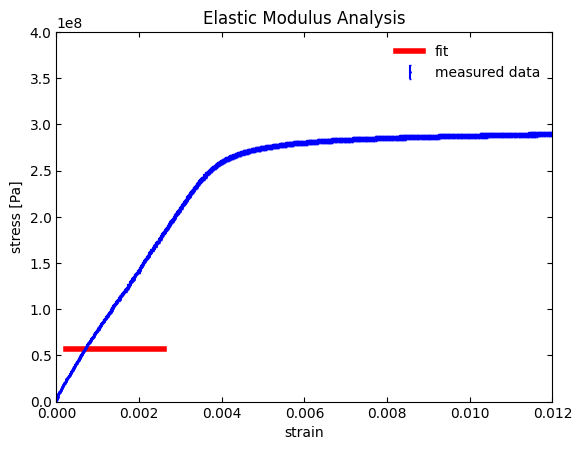

intercept = 57136997.6 Pa
intercept std. error = inf Pa
slope = 1.0 Pa
slope std. error = inf Pa
R squared: -1.17499


In [3]:
# Set the range to fit over
min_index = 30
max_index = 300

# Data to fit
strain_fit = strain[min_index : max_index]
u_strain_fit = u_strain[min_index : max_index]
stress_fit = stress[min_index : max_index]
u_stress_fit = u_stress[min_index : max_index]

# Perform the least-squares fitting
popt, pcov = curve_fit(linearFunc, strain_fit, stress_fit, sigma=u_stress_fit, absolute_sigma=True)

# Extract out the fitted parameters and standard errors
intercept = popt[0]
slope = popt[1]
intercept_err = np.sqrt(pcov[0][0])
slope_err = np.sqrt(pcov[1][1])

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data
ax.errorbar(strain, stress,
            yerr=u_stress,
            label="measured data",
            marker="o",
            markersize=1,
            linestyle="none",
            color="blue",
            capsize=1)

# Create fitted curve
yfit = (slope * strain_fit) + intercept

# Plot fit data
ax.plot(strain_fit, yfit, 
        color="red",
        label="fit",
        linestyle="solid",
        linewidth=4)

# Figure options
ax.set_title("Elastic Modulus Analysis")
ax.set_xlabel("strain")
ax.set_ylabel("stress [Pa]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
ax.set_xlim(left=0, right=0.012)
ax.set_ylim(bottom=0, top=400E6)
ax.legend(frameon=False)

# Show plot
plt.show()

# R^2 analysis
y_data = stress_fit

y_mean = np.mean(y_data)
deviation_squared = (y_data - y_mean)**2
ss_tot = np.sum(deviation_squared)
error_squared = (y_data - yfit)**2
ss_res = np.sum(error_squared)
r_squared = 1 - ss_res / ss_tot

# Report values to shell
print(f"intercept = {intercept:.1f} Pa")
print(f"intercept std. error = {intercept_err:.1f} Pa")
print(f"slope = {slope:.1f} Pa")
print(f"slope std. error = {slope_err:.1f} Pa")
print(f"R squared: {r_squared:.5f}")

If everything ran correctly, you should see an **incorrect** fit. On the positive side, we can see 
that the fitted curve (represented by the red line) only appears in the linear region of the curve. However, our 
fitted line is horizontal (i.e., no slope), does not fit well at all, and we have the traceback warning:

```
OptimizeWarning: Covariance of the parameters could not be estimated
```

This warning is important as it leads us into our next section about fitting parameter initialization.

## Parameter optimization

In order to determine the values of fitting parameters, least squares regression analysis (i.e., the algorithm we are 
using in our fitting analysis) requires initial guesses of the fitting parameters. Many fitting programs often 
initialize each parameter to simple values like 0 or 1. These initial guesses, while usually wrong, still 
provide an OK starting point for optimization. However, these initial guesses may sometimes lead the fitting program to not 
properly converge to optimized final values. This can happen when the fitting function is mathematically complex 
or if there is a large dynamic range in values to fit over. This latter scenario is what we are dealing with in our 
case. Notice that the stress values in our data set span from 9.9&#183;10{sup}`3` Pa to 2.0&#183;10{sup}`8`, a 
4-5 order of magnitude change in stress.


SciPy's [`.optimize.curvefit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
function by default sets all values initially to 1. In order to change this default state we add the additional 
argument `p0` to the function call. For multiple fitting parameters, `p0` accepts a `list` with the index order 
representing the argument order of each parameter in the fitting function (note: the order starts AFTER the independent 
variable's position in the function call, which should be the first argument). What 
this means for us is that our `p0` argument value will follow the format 
`[intercept initial value, slope initial value]` because we defined our fitting function earlier as,

```
def linearFunc(x, intercept, slope):
    y = intercept + slope * x
    return y
```

Again, we ignore `x` since it is the independent variable in `linearFunc()`(see the 
[documentation on `scipy.optimize.curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) 
for details, specifically the parameters section for `f`). The next variable in `linearFunc()` is `intercept`, so 
this is why its initial guess will be the first value in our `p0` list, followed by the initial guess for `slope`.

So what values should we use? That is where the intuition of the scientist / engineer comes in! There are a few 
ways we can determine estimates on these values. Let's start with the initial guess for `intercept`. Here, we can 
look at the data and notice that the first few data points do start near the origin of the figure (i.e., (0,0) on the figure). 
So a good initial guess for the intercept seems to be `0`. The slope needs a little more effort. If we knew what the 
material actually was (e.g., copper, titanium, 1018 steel) we could use a reference value of its elastic 
modulus for the initial guess. We don't have this luxury here. Instead, let's quickly approximate the slope of this 
linear region. Looking at the plot we can see that at ~0.001 units of strain the stress is ~0.75&#183;10{sup}`8` Pa. 
Furthermore, at ~0.002 units of strain the stress is now ~1.5&#183;10{sup}`8` Pa. Therefore, we can approximate the 
slope as:

$$
\frac{1.5 \cdot 10^8 \space \text{Pa} - 0.75 \cdot 10^8 \space \text{Pa}}{0.002 - 0.001} = 75 \cdot 10^9 \space \text{Pa}
$$

While very approximate, this value will still be useful as an initial guess for `slope`. Therefore, our `p0` 
argument for `scipy.optimize.curvefit()` is `p0=[0, p0=[0, 75E9]]`. The code below is an updated version for our 
earlier code block but now with `p0` as an input argument:

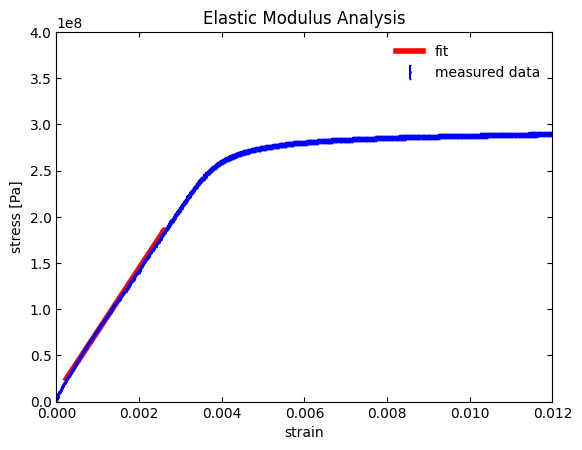

intercept = 8359383.4 Pa
intercept std. error = 53202.0 Pa
slope = 67935839663.8 Pa
slope std. error = 59039285.4 Pa
R squared: 0.99887


In [4]:
# Set the range to fit over
min_index = 30
max_index = 300

# Data to fit
strain_fit = strain[min_index : max_index]
u_strain_fit = u_strain[min_index : max_index]
stress_fit = stress[min_index : max_index]
u_stress_fit = u_stress[min_index : max_index]

# Perform the least-squares fitting
popt, pcov = curve_fit(linearFunc, strain_fit, stress_fit, p0=[0, 75E9], sigma=u_stress_fit, absolute_sigma=True)

# Extract out the fitted parameters and standard errors
intercept = popt[0]
slope = popt[1]
intercept_err = np.sqrt(pcov[0][0])
slope_err = np.sqrt(pcov[1][1])

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data
ax.errorbar(strain, stress,
            yerr=u_stress,
            label="measured data",
            marker="o",
            markersize=1,
            linestyle="none",
            color="blue",
            capsize=1)

# Create fitted curve
yfit = (slope * strain_fit) + intercept

# Plot fit data
ax.plot(strain_fit, yfit, 
        color="red",
        label="fit",
        linestyle="solid",
        linewidth=4)

# Figure options
ax.set_title("Elastic Modulus Analysis")
ax.set_xlabel("strain")
ax.set_ylabel("stress [Pa]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
ax.set_xlim(left=0, right=0.012)
ax.set_ylim(bottom=0, top=400E6)
ax.legend(frameon=False)

# Show plot
plt.show()

# R^2 analysis
y_data = stress_fit

y_mean = np.mean(y_data)
deviation_squared = (y_data - y_mean)**2
ss_tot = np.sum(deviation_squared)
error_squared = (y_data - yfit)**2
ss_res = np.sum(error_squared)
r_squared = 1 - ss_res / ss_tot

# Report values to shell
print(f"intercept = {intercept:.1f} Pa")
print(f"intercept std. error = {intercept_err:.1f} Pa")
print(f"slope = {slope:.1f} Pa")
print(f"slope std. error = {slope_err:.1f} Pa")
print(f"R squared: {r_squared:.5f}")

Sure enough, we now get a good fit! Our $R^2$ value is near 1 (i.e., a near perfect fit to a line) and the slope is 
$67.9 \cdot 10^9 \space \text{Pa}$, which matches well with our crude initial guess.


## Conclusion

In this lesson we showed how to provide bounds to our fit and initial guesses to our fitting parameters. Both topics 
proved to be useful in order to properly fit and display our results. In the end, it only took a few additional 
lines of code and some intuition from us for reasonable fitting ranges and values. To summarize what we did in this 
lesson, the code block below is a self-contained version of our fitting example that includes all the necessary 
steps to properly fit the data set.

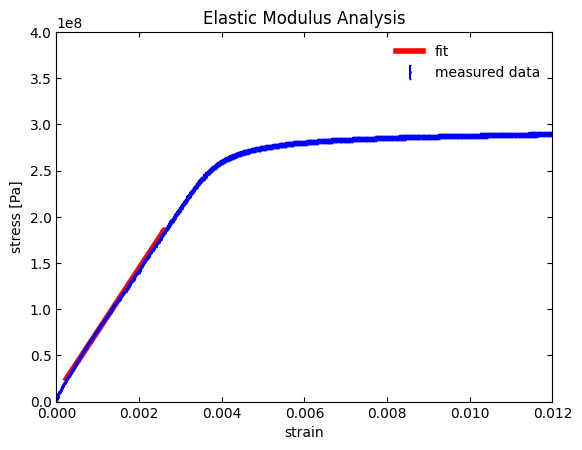

intercept = 8359383.4 Pa
intercept std. error = 53202.0 Pa
slope = 67935839663.8 Pa
slope std. error = 59039285.4 Pa
R squared: 0.99887


In [5]:
# Full fitting program

# Load libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# Create function to fit
def linearFunc(x, intercept, slope):
    y = intercept + slope * x
    return y

# Load data
data = np.loadtxt("./example_data/ElasticModulus_analysis.csv", 
                   delimiter=",", 
                   skiprows=2)
# Data file has the following columns:
    # Column 0: strain
    # Column 1: uncertainty on strain
    # Column 2: stress [Pa]
    # Column 3: uncertainty on stress [Pa]

# Save relevant data to variables
strain = data[:, 0]
u_strain = data[:, 1]
stress = data[:, 2]
u_stress = data[:, 3]

# Set the range to fit over
min_index = 30
max_index = 300

# Data to fit
strain_fit = strain[min_index : max_index]
u_strain_fit = u_strain[min_index : max_index]
stress_fit = stress[min_index : max_index]
u_stress_fit = u_stress[min_index : max_index]

# Perform the least-squares fitting
popt, pcov = curve_fit(linearFunc, strain_fit, stress_fit, p0=[0, 75E9], 
                       sigma=u_stress_fit, absolute_sigma=True)

# Extract out the fitted parameters and standard errors
intercept = popt[0]
slope = popt[1]
intercept_err = np.sqrt(pcov[0][0])
slope_err = np.sqrt(pcov[1][1])

# Create figure
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# Plot measured data
ax.errorbar(strain, stress,
            yerr=u_stress,
            label="measured data",
            marker="o",
            markersize=1,
            linestyle="none",
            color="blue",
            capsize=1)

# Create fitted curve
yfit = (slope * strain_fit) + intercept

# Plot fit data
ax.plot(strain_fit, yfit, 
        color="red",
        label="fit",
        linestyle="solid",
        linewidth=4)

# Figure options
ax.set_title("Elastic Modulus Analysis")
ax.set_xlabel("strain")
ax.set_ylabel("stress [Pa]")
ax.tick_params(axis="both", direction="in")
ax.tick_params(top="on")
ax.tick_params(right="on")
ax.set_xlim(left=0, right=0.012)
ax.set_ylim(bottom = 0, top=400E6)
ax.legend(frameon=False)

# Show plot
plt.show()

# R^2 analysis
y_data = stress_fit

y_mean = np.mean(y_data)
deviation_squared = (y_data - y_mean)**2
ss_tot = np.sum(deviation_squared)
error_squared = (y_data - yfit)**2
ss_res = np.sum(error_squared)
r_squared = 1 - ss_res / ss_tot

# Report values to shell
print(f"intercept = {intercept:.1f} Pa")
print(f"intercept std. error = {intercept_err:.1f} Pa")
print(f"slope = {slope:.1f} Pa")
print(f"slope std. error = {slope_err:.1f} Pa")
print(f"R squared: {r_squared:.5f}")

## Want to learn more?

[SciPy Library - The curve_fit() Function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)  
[Wikipedia - Least Squares](https://en.wikipedia.org/wiki/Least_squares)  
[Wikipedia - Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)